<a id="top"></a>
# HSTaXe Cookbook: Spectral Extraction for WFC3/IR 

This notebook contains a step-by-step guide for performing spectral extractions with HSTaXe for G102 (or G141) data from WFC3/IR. <br>
The original source for this notebook is the "cookbook" folder on the [spacetelescope/hstaxe](https://github.com/spacetelescope/hstaxe) GitHub repository. 

***
## Learning Goals
In this tutorial, you will:

- Organize input data
- Run custom background subtraction code
- Set up HSTaXe and prepare data for extraction
- Learn how to handle different types of background subtraction
- Extract 1-D spectra with a simple box extraction

## Table of Contents

[1. Introduction](#intro)<br>
[2. Imports](#import)<br>
[3. Setup](#setup)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Run WFC3 Backsub and Calibrate](#cal)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Verify Matching WCS Information](#wcs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3 Drizzling Input Data](#drizzle)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Creating a Catalog with SExtractor](#catalog)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5 Copy Catalog and Rename Mag Column](#copycat)<br>
[4. Running HSTaXe](#axe)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Basic Extraction](#basic) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.1 Basic Outputs](#out) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2. Fluxcube Extraction](#fluxcube) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.1 Fluxcube Outputs](#outcube) <br>
[5. Conclusions](#conclusions)<br>
[6. About this Notebook](#about)<br>
[7. Citations](#cite)<br>

# 1. Introduction <a id="intro"></a>

[HSTaXe](https://hstaxe.readthedocs.io/en/latest/index.html) is a Python package that provides spectral extraction processes for HST data. **Please be aware that running this notebook requires creating a conda environment from the provided `.yaml` file in this notebook's [github repository](https://github.com/spacetelescope/hstaxe/tree/main/cookbooks).** For more details about creating the necessary environment see the notebook's README file.

Below, we show two workflows for spectral extraction using WFC3/IR G102 grism data. The first workflow performs a basic image-by-image box extraction, while the latter uses a flux cube technique. **The example data we use in this notebook (from WFC3 CAL program 16582) are available [here](https://stsci.box.com/s/j2ygj4gaqgzmp0b4xcc1h2rszz6cv9wm).** If you would like to use this notebook with the example data, please download the `example_data` subdirectory from the link above, and store it within the same parent directory as this notebook. Once you have the example data directory, this notebook is intended to run continuously without needing to edit any of the cells. 

In addition to the example data, **this notebook also requires configuration files for HSTaXe, which can be downloaded [here](https://stsci.box.com/s/ojbj3v4twkpkqt6tj9hwg1xkzbhrugm4).** The `WFC3_IR_conf` directory should be stored in the  same parent directory as this notebook, and later we will be copy them to the `CONF` subdirectory created by HSTaXe.

**When analyzing WFC3/IR grism data, it is strongly advised that you calibrate the raw grism FITS files with the program WFC3 Backsub available [here](https://stsci.box.com/s/xrz16v1tv58y8vcfy8zlrn83jrpnam19).** In order to run this notebook, please download the entire `WFC3_Backsub` folder from the provided link, which includes `back_sub.py` as well as a folder of reference FITS files called `backsub_data`, and put it in the same parent directory as this notebook.

**If you plan to use your own data with this notebook, please be aware you will be required to create an input source catalog with SExtractor.** Information regarding SExtractor including installation instructions are available [here](https://sextractor.readthedocs.io/en/latest/Installing.html). In addition to installing SExtractor, you must run the software with aXe specific configuration files. **These aXe-SExtractor configuration files can be downloaded [here](https://stsci.box.com/s/3npry36gu7ocfnuxgzwr5syj4i8r7hy8).** Once SExtractor is installed, create a `sextractor` directory in the same parent directory as this notebook, and place configuration files inside. 

# 2. Imports <a id="import"></a>

For this workflow, we will import the following modules:

- *os*, *glob* and *shutil*, for file handling
- *numpy* for array handling
- *astropy.io.fits* for FITS file handling
- *astropy.table.Table* for table functions
- *ginga.util.zscale* for image display scaling
- *matplotlib.pyplot* for plotting
- *stwcs.updatewcs* for matching grism and direct image WCS
- *astrodrizzle* for creating input image mosaics
- *hstaxe.axetasks* for performing the spectral extraction
- *wfc3tools.calwf3* for background subtraction and image reduction

In [1]:
%matplotlib inline

import os
import shutil
import glob
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import matplotlib.pyplot as plt
from ginga.util import zscale
from stwcs import updatewcs
from drizzlepac import astrodrizzle
from hstaxe import axetasks
from wfc3tools import calwf3



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Saving hstaxe logging to 'axe_output.log'

*********************************************************************
* Welcome to hstaxe!
This version is independent of IRAF and PyRAF. *
*********************************************************************

AXE_IMAGE_PATH already exists, using.
AXE_OUTPUT_PATH already exists, using.
AXE_CONFIG_PATH already exists, using.
AXE_DRIZZLE_PATH already exists, using.
AXE_SIMDATA_PATH already exists, using.
AXE_OUTSIM_PATH already exists,

## 3. Setup <a id="setup"></a>

We'll start our basic extraction workflow by organizing our input data. A set of example data are available [here](https://stsci.box.com/s/tpbhvrqtbtwod7tr7uijexttoocy4duj) for tutorial purposes. Note that many of the following steps will pre-process data that will only be used for the advanced extraction later in the notebook.

First, we save the working directory for this notebook.

In [2]:
cwd = os.getcwd()
print(f'The current directory is: {cwd}')

The current directory is: /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir


Next, we'll create directories for our grism and direct images. **HSTaXe will modify our input images in-place, so it is crucial to retain clean versions of them in another location, which will be copied into these directories.** If running this notebook multiple times, run all the lines in the next cell to clear any existing inputs.

In [3]:
os.chdir(cwd)
if os.path.isdir('g102'):
    shutil.rmtree('g102')
if os.path.isdir('f098m'):
    shutil.rmtree('f098m')
if os.path.isdir('f105w'):
    shutil.rmtree('f105w')
os.mkdir('g102')
os.mkdir('f098m')
os.mkdir('f105w')

Now, copy your images to the input directories.

In [4]:
# src = '/path/to/your/grism/images/*raw.fits'
src = 'example_data/g102/*raw.fits'
dst = 'g102/'
for f in glob.glob(src):
    shutil.copy(f, dst)

# src = '/path/to/your/direct/images/*raw.fits'
src = 'example_data/f098m/*raw.fits'
dst = 'f098m/'
for f in glob.glob(src):
    shutil.copy(f, dst)

# src = '/path/to/your/direct/images/*raw.fits'
src = 'example_data/f105w/*raw.fits'
dst = 'f105w/'
for f in glob.glob(src):
    shutil.copy(f, dst)

## 3.1 Run WFC3 Backsub and Calibrate Data <a id="cal"></a>

If you are working with WFC3/IR grism data (G102 and/or G141), we highly advise that you use the [WFC3 Backsub](https://stsci.app.box.com/folder/198794823506) program to process the RAW files into calibrated FLT files (see the [Introduction](intro) for download instructions). The G102 and G141 background sky signal is both variable and made up of multiple components, and the current version of the WFC3 calibration pipeline, `calwf3`, does not have the capability to model and remove this dispersed 2D background.  WFC3 Backsub is designed specifically to assess the level of each of the three components (zodiacal, 1.083 μm HeI emission, and scattered) and remove the signal during calibration. The `back_sub.py` program program still relies on and uses `calwf3` for calibration (e.g. bias correction and dark subtraction), but it employs custom reference files (not available in the Calibration Reference Data System (CRDS)) to measure and remove the multiple sky components before the final "up-the-ramp" fitting occurs in `calwf3`.   


WFC3 Backsub was originally written by [Dr. Norbert Pirzkal](https://www.stsci.edu/stsci-research/research-directory/nor-pirzkal) (at STScI) for his scientific work with the [Faint Infrared Grism Survey](https://ui.adsabs.harvard.edu/abs/2017ApJ...846...84P/abstract). While the code was originally posted on Dr. Pirzkal's personal GitHub repository, we have taken it and updated some of the syntax and procedures to work with the HSTaXe cookbook environment and have it hosted on [STScI's Box](https://stsci.app.box.com/folder/193831769414) now. A description of the three background components and the methods used in WFC3 Backsub can be found in [WFC3 ISR 2020-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2020/WFC3_IR_2020-04.pdf) (Pirzkal & Ryan). For more information on WFC3 IR calibration as well as the IR variable background please see Chapters [3](https://hst-docs.stsci.edu/wfc3dhb/chapter-3-wfc3-data-calibration/3-3-ir-data-calibration-steps) & [7](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background) of the [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb).

The cells below assume you have downloaded the `WFC3_backsub` directory from the provided Box link and have it in the same parent directory as this notebook.<br>
First, we will copy the `back_sub.py` file and the custom reference files over to the `grism_ims` directory.  

In [5]:
# src = '/path/to/your/WFC3_backsub/*.py'
src = 'WFC3_backsub/back_sub.py'
dst = 'g102/'
cl1 = os.system(f"cp {src} {dst}")

# src = '/path/to/your/WFC3_backsub/backsub_data/'
src = 'WFC3_backsub/backsub_data/'
dst = 'g102/backsub_data/'
cl2 = os.system(f"cp -R {src} {dst}")

if cl1 != 0 or cl2 !=0:
    print("backsub code and/or reference file data did not copy correctly")

With the `back_sub.py` program, custom reference files, and raw grism FITS files all in the same directory (`grism_ims`), we can call the code with the few command line arguments that it has: `grism`, `ipppss`, and `grey_flat`.

In [6]:
os.chdir('g102')

# set arguments for command line call
grism = 'G102'
ipppss = 'All'
grey_flat = True

# create command line call and run backsub
cl_input = f"python back_sub.py '*_raw.fits'  --grism={grism} --ipppss={ipppss} --grey_flat={grey_flat}"
cl = os.system(cl_input)
if cl != 0:
    print("Backsub program did not execute properly.")
    print("Be sure `back_sub.py`, `backsub_data` and raw grism files are all in the same directory.")

CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01pyq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01q1q_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01pvq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos




Will look for custom back_sub reference files in  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/g102/backsub_data/
Will look for standard reference files in  /Volumes/cdbs/iref/
args: *_raw.fits True
Loading  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/g102/backsub_data/G102_Zodi_CLN6_V9_b_clean.fits
Loading  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/g102/backsub_data/G102_HeI_V9_b_clean.fits
Loading  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/g102/backsub_data/G102_Scatter_V9_b_superclean.fits
Processing  ielf01pyq_raw.fits
git tag: UNKNOWN

git branch: UNKNOWN

HEAD @: UNKNOWN





CALBEG*** CALWF3 -- Version 3.6.2 (May-27-2021) ***

Begin    31-Mar-2023 16:32:32 EDT





Input    ielf01pyq_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open ielf01pyq_raw.fits...

Read in Primary header from ielf01pyq_raw.fits...

Creating new trailer file `ielf01pyq.tra'.





CALBEG*** WF3IR -- Version 3.6.2 (May-27-2021) ***


Writing out a priori WCS IDC_w3m18525i-GSC240 to headerlet file: ielf01pyq_flt_668208_hlet.fits
AstrometryDB service available...
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
Updating astrometry for ielf01q1q
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01q1q
No solutions found in database for ielf01q1q
Archiving pipeline-default WCS IDC_w3m18525i to ielf01q1q_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01q1q_flt_219774_hlet.fits
gsReference service retrieved IELF01Q1Q
....Updating header for ielf01q1q_flt.fits...
Initializing new WCSCORR table for  ielf01q1q_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,

Writing out a priori WCS IDC_w3m18525i-GSC240 to headerlet file: ielf01q1q_flt_668208_hlet.fits
AstrometryDB service available...
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
Updating astrometry for ielf01pvq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01pvq
No solutions found in database for ielf01pvq
Archiving pipeline-default WCS IDC_w3m18525i to ielf01pvq_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01pvq_flt_219774_hlet.fits
gsReference service retrieved IELF01PVQ
....Updating header for ielf01pvq_flt.fits...
Initializing new WCSCORR table for  ielf01pvq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,

Writing out a priori WCS IDC_w3m18525i-GSC240 to headerlet file: ielf01pvq_flt_668208_hlet.fits


/Users/bkuhn/miniconda3/envs/hstaxe_cookbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


You should now have calibrated FLT grism files inside of the `grism_ims` directory. With the grism images properly background subtracted and calibrated we can move on to calibrating the direct image exposures. For this, all we need to do is call `calwf3` on the RAW files after passing them through [CRDS `bestref`](https://hst-crds.stsci.edu/static/users_guide/basic_use.html).

Before running CRDS `bestref`, we need to set [CRDS environment variables](https://hst-crds.stsci.edu/docs/cmdline_bestrefs/).  We will point to a subdirectory called `crds_cache/` using the `IREF` environment variable. The `IREF` variable is used for WFC3 reference files and different instruments use other variables, e.g., `JREF` for ACS. You have the option to permanently add these environment variables to your user profile by adding the path in your shell's configuration file. If you are using bash, you would edit the `~/.bash_profile` file with lines such as:
```
export CRDS_PATH="$HOME/crds_cache"
export CRDS_SERVER_URL="https://hst-crds.stsci.edu"
export iref="${CRDS_PATH}/references/hst/iref/"
```
If you have already set up the CRDS environment variables you may skip running the cell below. 

In [7]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
if 'CRDS_PATH' not in os.environ.keys():
    os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'],'crds_cache')
if 'iref' not in os.environ.keys():
    os.environ['iref'] = '$HOME/crds_cache/references/hst/iref/'

Now that the CRDS environment variables are properly set, we can run the direct RAW files through `bestref` and then `calwf3`. <br>
If you have never used `bestrefs` before, the next cell may take a few minutes to download necessary reference file mappings.

In [8]:
os.chdir('../f098m')

raws = glob.glob('*raw.fits')
for file in raws:
    cl = f"crds bestrefs --files {file} --sync-references=1 --update-bestrefs"
    os.system(cl)

[calwf3(file) for file in raws]

os.chdir('../f105w')

raws = glob.glob('*raw.fits')
for file in raws:
    cl = f"crds bestrefs --files {file} --sync-references=1 --update-bestrefs"
    os.system(cl)

[calwf3(file) for file in raws]

CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01ptq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01pwq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01pzq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


git tag: UNKNOWN

git branch: UNKNOWN

HEAD @: UNKNOWN





CALBEG*** CALWF3 -- Version 3.6.2 (May-27-2021) ***

Begin    31-Mar-2023 16:36:59 EDT





Input    ielf01ptq_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open ielf01ptq_raw.fits...

Read in Primary header from ielf01ptq_raw.fits...

Creating new trailer file `ielf01ptq.tra'.





CALBEG*** WF3IR -- Version 3.6.2 (May-27-2021) ***

Begin    31-Mar-2023 16:37:00 EDT

Input    ielf01ptq_raw.fits

Output   ielf01ptq_flt.fits

Trying to open ielf01ptq_raw.fits...

Read in Primary header from ielf01ptq_raw.fits...

APERTURE GRISM1024

FILTER   F098M

DETECTOR IR

Reading data from ielf01ptq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICOR

CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01puq_raw.fits
CRDS - INFO -  Fetching  /Users/bkuhn/crds_cache/references/hst/wfc3/4ac1816oi_dfl.fits   10.5 M bytes  (1 / 2 files) (0 / 21.1 M bytes)
CRDS - INFO -  Fetching  /Users/bkuhn/crds_cache/references/hst/wfc3/4ac19225i_pfl.fits   10.5 M bytes  (2 / 2 files) (10.5 M / 21.1 M bytes)
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  4 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01pxq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ielf01q0q_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


git tag: UNKNOWN

git branch: UNKNOWN

HEAD @: UNKNOWN





CALBEG*** CALWF3 -- Version 3.6.2 (May-27-2021) ***

Begin    31-Mar-2023 16:38:43 EDT





Input    ielf01puq_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open ielf01puq_raw.fits...

Read in Primary header from ielf01puq_raw.fits...

Creating new trailer file `ielf01puq.tra'.





CALBEG*** WF3IR -- Version 3.6.2 (May-27-2021) ***

Begin    31-Mar-2023 16:38:43 EDT

Input    ielf01puq_raw.fits

Output   ielf01puq_flt.fits

Trying to open ielf01puq_raw.fits...

Read in Primary header from ielf01puq_raw.fits...

APERTURE GRISM1024

FILTER   F105W

DETECTOR IR

Reading data from ielf01puq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICOR

[None, None, None]

## 3.2 Verify WCS Information<a id="wcs"></a>

It is possible that the WCS in the direct and grism images differ. In this section we will use a function to process all the direct and grism images to verify that the WCS information is consistent throughout. If there is any disagreement in WCS information we call `updatewcs` with the database keyword set to False, which will roll back all the solutions to the original distortion-corrected WCS. For more information regarding HST WCS and improved absolute astrometry please see [WFC3 Instrument Science Report 2022-06](https://ui.adsabs.harvard.edu/abs/2022wfc..rept....6M/abstract) (Mack et al.). For documentations on `updatewcs` please see [here](https://stwcs.readthedocs.io/en/latest/updatewcs.html).

In [9]:
def check_wcs(images):
    """ A helper function to verify the active world coordinate solutions match and roll them back if they do not 
    
    Parameter
    ---------
    images : list 
        a list of grism and direct images 
        
    Return
    ------
    N/A
    """
    
    direct_wcs = []
    grism_wcs = []

    for f in images:
        # get filter for image to distinguish between direct and grism
        filt = fits.getval(f, 'FILTER')
        
        hdul = fits.open(f)
        db_bool = 'WCSCORR' not in hdul
        hdul.close()
        
        try:
            # get the active solution from the file's "SCI" extension
            wcsname = fits.getval(f, 'WCSNAME', ext=('SCI', 1))
            if db_bool == True:
                updatewcs.updatewcs(f,use_db=db_bool)
        except KeyError:
            updatewcs.updatewcs(f,use_db=db_bool)
            wcsname = fits.getval(f, 'WCSNAME', ext=('SCI', 1))
        
        # seperate between direct and grism
        if 'G' in filt:
            grism_wcs.append(wcsname)
        if 'F' in filt:
            direct_wcs.append(wcsname)

    # get the number of unique active solutions in the direct and grism images       
    num_wcs_direct = len(set(direct_wcs))
    num_wcs_grism = len(set(grism_wcs))

    # roll back WCS on all files if there is more than one active solution for either direct or grism images
    if num_wcs_direct > 1 or num_wcs_grism > 1:
        [updatewcs.updatewcs(file,use_db=False) for file in images]
        print('WCS reset complete')

    # roll back WCS on all files if the active solution for the direct images do not match the grism images
    elif set(direct_wcs) != set(grism_wcs):
        [updatewcs.updatewcs(file,use_db=False) for file in images]
        print('WCS reset complete')

    # do nothing if there is one unique active solution and they match
    elif set(direct_wcs) == set(grism_wcs):
        print(f"No WCS update needed. All grism and direct images use WCS: {grism_wcs[0]}.")

In [10]:
os.chdir(cwd)
all_images = glob.glob('f098m/i*_flt.fits')+\
             glob.glob('f105w/i*_flt.fits')+\
             glob.glob('g102/i*_flt.fits')
check_wcs(all_images)

AstrometryDB service available...
- IDCTAB: Distortion model from row 6 for chip 1 : F098M
- IDCTAB: Distortion model from row 6 for chip 1 : F098M
Updating astrometry for ielf01ptq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01ptq
No solutions found in database for ielf01ptq
Archiving pipeline-default WCS IDC_w3m18525i to ielf01ptq_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01ptq_flt_219774_hlet.fits
gsReference service retrieved IELF01PTQ
....Updating header for /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f098m/ielf01ptq_flt.fits...
Initializing new WCSCORR table for  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f098m/ielf01ptq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SI

AstrometryDB service available...
- IDCTAB: Distortion model from row 6 for chip 1 : F098M
- IDCTAB: Distortion model from row 6 for chip 1 : F098M
Updating astrometry for ielf01pzq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01pzq
No solutions found in database for ielf01pzq
Archiving pipeline-default WCS IDC_w3m18525i to ielf01pzq_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01pzq_flt_219774_hlet.fits
gsReference service retrieved IELF01PZQ
....Updating header for /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f098m/ielf01pzq_flt.fits...
Initializing new WCSCORR table for  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f098m/ielf01pzq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SI

AstrometryDB service available...
- IDCTAB: Distortion model from row 6 for chip 1 : F098M
- IDCTAB: Distortion model from row 6 for chip 1 : F098M
Updating astrometry for ielf01pwq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01pwq
No solutions found in database for ielf01pwq
Archiving pipeline-default WCS IDC_w3m18525i to ielf01pwq_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01pwq_flt_219774_hlet.fits
gsReference service retrieved IELF01PWQ
....Updating header for /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f098m/ielf01pwq_flt.fits...
Initializing new WCSCORR table for  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f098m/ielf01pwq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SI

AstrometryDB service available...
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
Updating astrometry for ielf01pxq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01pxq
No solutions found in database for ielf01pxq
Archiving pipeline-default WCS IDC_w3m18525i to ielf01pxq_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01pxq_flt_219774_hlet.fits
gsReference service retrieved IELF01PXQ
....Updating header for /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f105w/ielf01pxq_flt.fits...
Initializing new WCSCORR table for  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f105w/ielf01pxq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SI

AstrometryDB service available...
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
Updating astrometry for ielf01puq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01puq
No solutions found in database for ielf01puq
Archiving pipeline-default WCS IDC_w3m18525i to ielf01puq_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01puq_flt_219774_hlet.fits
gsReference service retrieved IELF01PUQ
....Updating header for /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f105w/ielf01puq_flt.fits...
Initializing new WCSCORR table for  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f105w/ielf01puq_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SI

AstrometryDB service available...
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
Updating astrometry for ielf01q0q
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/ielf01q0q
No solutions found in database for ielf01q0q
Archiving pipeline-default WCS IDC_w3m18525i to ielf01q0q_flt.fits
Writing out pipeline-default WCS IDC_w3m18525i to headerlet file: ielf01q0q_flt_219774_hlet.fits
gsReference service retrieved IELF01Q0Q
....Updating header for /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f105w/ielf01q0q_flt.fits...
Initializing new WCSCORR table for  /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-ir/f105w/ielf01q0q_flt.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SI

No WCS update needed. All grism and direct images use WCS: IDC_w3m18525i-GSC240.


## 3.3 Drizzling the Input Data<a id="drizzle"></a>
The next step is to drizzle the grism images. We'll need a list of the image names to feed to AstroDrizzle. After that, we'll do the same for the direct images, but use the drizzled grism image as a reference, which will ensure proper registration between the data. HSTaXe will use these linked drizzle images to locate spectral traces based on the positions of sources in the direct images.

In [11]:
# Create list file using images in grism directory
os.chdir('g102')

lis = open('g102.lis', 'w')
for f in sorted(os.listdir('.')):
    if f[-8:] == 'flt.fits':
    #if os.path.splitext(f)[1]=='.fits':
        lis.write(f)
        lis.write('\n')
lis.close()

!cat g102.lis

ielf01pvq_flt.fits
ielf01pyq_flt.fits
ielf01q1q_flt.fits


In [12]:
# Drizzle grism images. If only using one input image, set blot, median, driz_cr to False
astrodrizzle.AstroDrizzle('@g102.lis', output='g102', mdriztab=True, 
                          preserve=False, skysub=False, final_fillval=None)

Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 16:38:58.769 (31/03/2023)

==== Processing Step  Initialization  started at  16:38:58.77 (31/03/2023)

Reading in MDRIZTAB parameters for 3 files
- MDRIZTAB: AstroDrizzle parameters read from row 5.
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 291.09524130130114  9.906203738324749  
CRPIX : 581.5  713.5  
CD1_1 CD1_2  : 1.8167975249924296e-05  3.064417329513966e-05  
CD2_1 CD2_2  : 3.064417329513966e-05  -1.8167975249924296e-05  
NAXIS : 1163  1427
********************************************************************************
*
*  Estimated memory usage:  up to 26 Mb.
*  Output image size:       1163 X 1427 pixels. 
*  Output image file:       ~ 18 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 16:38:59.230 (31/03/2023)

==== Processing Step Final Drizzle finished at 16:39:01.383 (31/03/2023)

AstroDrizzle Version 3.5.1 is finished processing at 16:39:01.384 (31/03/2023).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.4575 sec.
            Static Mask          0.0807 sec.
           Subtract Sky          1.0250 sec.
       Separate Drizzle          0.0010 sec.
          Create Median          0.0000 sec.
                   Blot          0.0012 sec.
                Driz_CR          0.0000 sec.
          Final Drizzle          1.0390 sec.
   ====================          ====================
                  Total          2.6044 sec.

Trailer file written to:  astrodrizzle.log


In [13]:
# List files for direct images
os.chdir(cwd)
os.chdir('f098m')

lis = open('f098m.lis', 'w')
for f in sorted(os.listdir('.')):
    if f[-8:] == 'flt.fits':
    # if os.path.splitext(f)[1]=='.fits':
        lis.write(f)
        lis.write('\n')
lis.close()
!cat f098m.lis

os.chdir('../f105w')

lis = open('f105w.lis', 'w')
for f in sorted(os.listdir('.')):
    if f[-8:] == 'flt.fits':
    # if os.path.splitext(f)[1]=='.fits':
        lis.write(f)
        lis.write('\n')
lis.close()

os.chdir(cwd)

ielf01ptq_flt.fits
ielf01pwq_flt.fits
ielf01pzq_flt.fits


Next, drizzle the direct images using the drizzled grism mosaic as a reference to ensure proper registration. For more information please see the `AstroDrizzle` documentation [here](https://drizzlepac.readthedocs.io/en/latest/astrodrizzle.html).

In [14]:
ref = '../g102/g102_drz.fits[1]'
os.chdir('f098m')
astrodrizzle.AstroDrizzle("@f098m.lis", output="f098m", mdriztab=True, 
                          preserve=False, skysub=False, final_fillval=None)
os.chdir('../f105w')
astrodrizzle.AstroDrizzle("@f105w.lis", output="f105w", mdriztab=True, 
                          preserve=False, skysub=False, final_fillval=None)

Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 16:39:01.646 (31/03/2023)

==== Processing Step  Initialization  started at  16:39:01.647 (31/03/2023)

Reading in MDRIZTAB parameters for 3 files
- MDRIZTAB: AstroDrizzle parameters read from row 2.
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 291.09523635494276  9.906200526133796  
CRPIX : 581.5  713.5  
CD1_1 CD1_2  : 1.8167975249924296e-05  3.064417329513966e-05  
CD2_1 CD2_2  : 3.064417329513966e-05  -1.8167975249924296e-05  
NAXIS : 1163  1427
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1163 X 1427 pixels. 
*  Output image file:       ~ 18 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step Initialization finished at 16:39:02.258 (31/03/2023

Your grism and direct images should now be aligned. For the WFC3/IR grisms, there should be very little vertical offset between the positions of sources in the direct image and their correspondents in the grism image. We'll perform a quick visual check here:

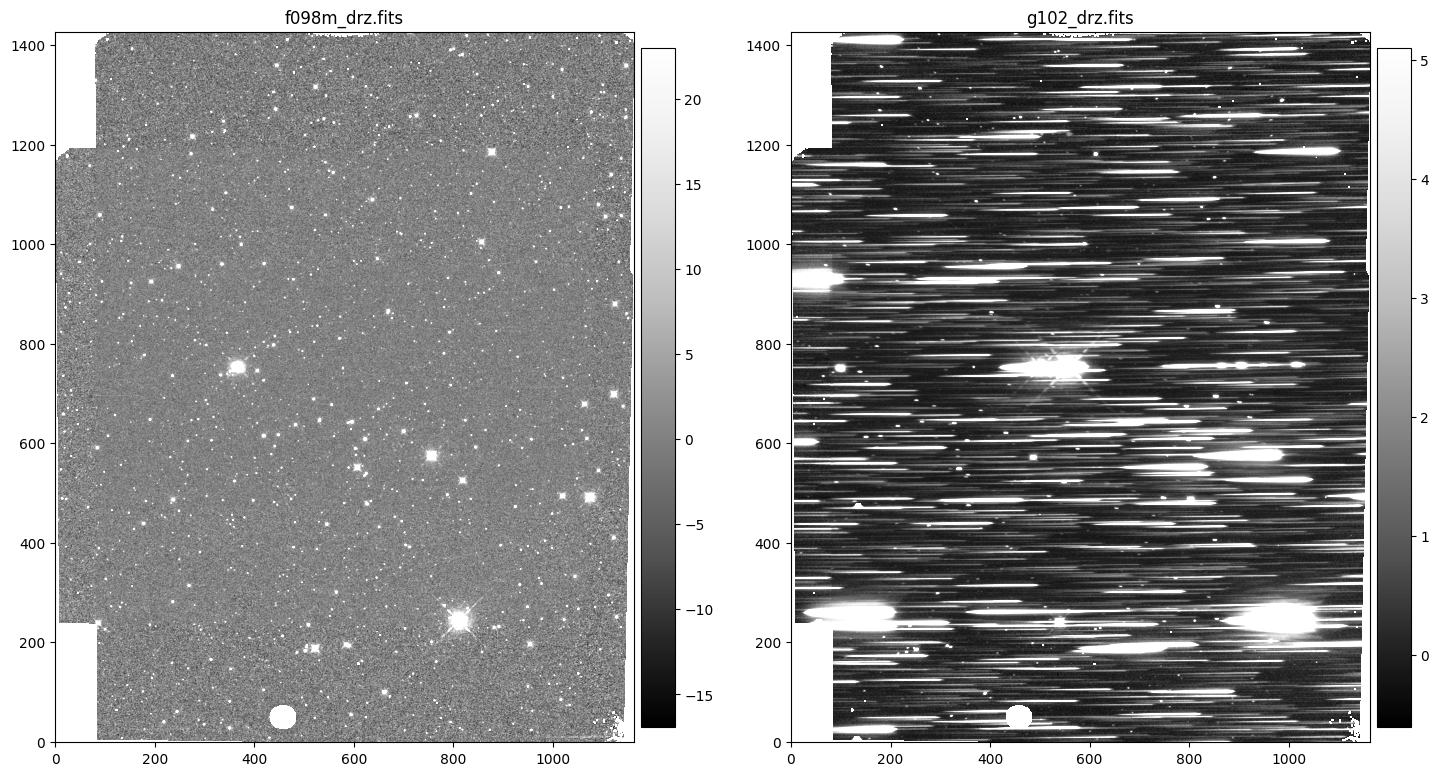

In [15]:
os.chdir(cwd)
fig, axs = plt.subplots(1, 2, figsize=(15,10), dpi=100)

d = fits.getdata('f098m/f098m_drz.fits', 1)
z1,z2 = zscale.zscale(d)
im1 = axs[0].imshow(d, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)
axs[0].set_title('f098m_drz.fits')
fig.colorbar(im1,shrink=0.7,pad=0.01)

d = fits.getdata('g102/g102_drz.fits', 1)
z1,z2 = zscale.zscale(d)
im2 = axs[1].imshow(d, origin='lower', cmap='Greys_r', vmin=z1, vmax=z2)
axs[1].set_title('g102_drz.fits')
fig.colorbar(im2,shrink=0.7,pad=0.01)

plt.tight_layout()

## 3.4 Creating a Catalog with SExtractor <a id="catalog"></a>

This section is intended for anyone using data other than the `example_data` provided for this notebook. Since we also provide a catalog in the `example_data` directory and will not formally run SExtractor here, we want to explain the process behind using the drizzle image to create a new catalog with SExtractor. **Please refer to the links in the [Introduction](#intro) section for instructions regarding installing SExtractor and downloading the necessary aXe-SExtractor configuration files.**

HSTaXe will look for a highly specific format in the catalog, and does not always give clear error messages when something within the catalog is awry. If creating a catalog yourself, please follow the next steps carefully:

1. Copy the drizzled direct image into the `sextractor` directory (once created), which contains HSTaXe-appropriate configuration files for SExtractor.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>Example code:</u>
```python
shutil.copy('direct_ims/direct_drz.fits', 'sextractor/')
```
2. With SExtractor installed, run the follow"ing command from within the `sextractor` directory that you created:
   
   `sex -c aXe.sex direct_drz.fits[1] -DETECT_THRESH 5 -MAG_ZEROPOINT 26.4525`

    Note that the value for the `DETECT_THRESH` keyword, which sets the minimum value for pixels to be considered, may be changed appropriately for your data. `MAG_ZEROPOINT` should also be changed to match the magnitude zeropoint of the direct image filter for your data. A table is provided below containing the pivot wavelengths and zeropoints for the WFC3/IR grism reference filters.
    
| Filter | Pivot Wavelength (nm) | Zeropoint (ABmag |
|:--------|-----------------------|------------------|
| F098M  |         986.4         |      25.666      |
| F105W  |          1055         |      26.264      |
| F140W  |          1392         |      26.450      |
| F160W  |          1537         |      25.936      |

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>Example code:</u>
```python
os.chdir('sextractor')
detect_thresh = 10
cl_input = f'sex -c aXe.sex direct_drz.fits[1] -DETECT_THRESH {detect_thresh} -MAG_ZEROPOINT 25.666'
os.system(cl_input)
``` 
3. At this point you should have created a catalog. The next steps include copying the file into the `direct_ims` directory and editing the name of the `MAG_ISO` column. See [Section 2.3](#copycat) for information regarding renaming the `MAG_ISO` column. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>Example code:</u>
```python
os.chdir(cwd)
shutil.copy('sextractor/aXe.cat', 'direct_ims')
```

## 3.5 Copy Catalog and Rename Mag Column <a id="copycat"></a>

The catalog corresponding to the data used in this notebook is included in the `example_data` directory downloaded in the Introduction section. Start by copying the catalog into the `direct_ims` directory.

In [16]:
# Copy the example catalog to the direct image directory:
os.chdir(cwd)
shutil.copy('example_data/aXe.cat', 'f098m');

In [17]:
cat = Table.read('f098m/aXe.cat', format='ascii.sextractor')
cols_to_show = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'A_IMAGE', 'B_IMAGE', 'MAG_ISO', 'MAGERR_ISO']
cat[cols_to_show].show_in_notebook()

idx,NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,MAG_ISO,MAGERR_ISO
,,pix,pix,pix,pix,mag,mag
0,1,351.5617,29.5287,0.499,0.496,16.6791,0.0022
1,2,595.0102,56.4853,0.756,0.5,16.6323,0.0025
2,3,661.669,101.6491,0.915,0.832,15.2672,0.0011
3,4,523.1949,189.3028,1.064,0.967,13.512,0.0003
4,5,953.8915,197.6831,0.947,0.864,15.0715,0.001
5,6,592.0045,194.9271,0.759,0.749,16.0354,0.0018
6,7,585.0298,197.0233,0.928,0.715,15.262,0.001
7,8,811.1258,244.7002,3.217,3.102,12.2543,0.0002
8,9,891.5037,233.478,0.5,0.499,17.0331,0.003


Examine the catalog. The "MAG_ISO" column must be renamed to "MAG_F####" for the catalog to be correctly read in by HSTaXe. Where "####" is the pivot wavelength of the direct image filter in nm (Å for WFC3/UVIS, e.g. 4971 for F200LP and 1392 for F140W). Please see WFC3 Instrument Handbook Section 7.5 ["IR Spectral Elements"](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-5-ir-spectral-elements) for information about IR filter pivot wavelengths. You can also refer to the table above as a quick-reference for the pivot wavelength of the recommended direct image filters for the IR grisms.

Any lines in the catalog containing clearly spurious detections, such as those with magnitudes of 99.0, should also be removed. **Note**: Removing spurious detections is not a part of this notebook and will need to be done manually. 


Lastly, locate the lines containing the sources whose spectra you want to extract and note the line number from the NUMBER column. This will be used later to identify the BEAM number for your object in the output files.

To avoid having to edit the column information manually in the SExtractor catalog, there is a helper function below called `edit_catalog_pivot`. It takes in the SExtractor catalog, output file path/name, and the pivot wavelength value and edits the information and writes to the output file. 

In [18]:
def edit_catalog_pivot(inputfile, outputfile, pivot_wave):
    """ Function to edit the auto-generated sextractor header/column name so aXe will run
        
        Parameters
        ----------
        inputfile : str
            The full path to the input catalog including filename
        outputfile : str
            The full path to the output catalog including filename
        pivot_wave : int or str
            The pivot wavelength of filter used in the driect image
            For UVIS please use 4 digits in units of Angstrom and 
            for IR please use 4 ditits in units of nanometers 
            
        Return
        ------
        Nothing. But a file is written to `outputfile`
    """
    # Read in the input catalog
    with open(inputfile, 'r') as f:
        lines = f.readlines()

    with open(outputfile, 'w') as f:
        # Find the mag_iso row and replace with pivot wavelength
        for line in lines:
            line = line.replace('MAG_ISO', f'MAG_F{pivot_wave}')
            f.write(line)

In [19]:
inputfile = 'f098m/aXe.cat'
outputfile = 'f098m/aXe_ir_f098m.cat'
pivot_wave = 986 # nm
edit_catalog_pivot(inputfile, outputfile, pivot_wave)

In [20]:
# Use this cell to filter your catalog for your sources
# In this example, we sort to identify the brightest sources
cat = Table.read(outputfile, format='ascii.sextractor')
cat.sort(f'MAG_F{pivot_wave}')
cols_to_show = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'FLUX_RADIUS', 'MAG_F986', 'MAGERR_ISO']
cat[cols_to_show].show_in_notebook()

idx,NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLUX_RADIUS,MAG_F986,MAGERR_ISO
,,pix,pix,pix,pix,deg,pix,mag,mag
0,8,811.1258,244.7002,3.217,3.102,49.01,3.167,12.2543,0.0002
1,19,367.3264,753.7507,2.415,2.174,-11.08,2.074,12.5991,0.0002
2,28,756.2592,575.9573,1.293,1.214,3.12,1.306,12.9385,0.0002
3,33,1073.8584,492.7767,1.336,1.266,2.31,1.456,13.4127,0.0003
4,4,523.1949,189.3028,1.064,0.967,-2.63,1.03,13.512,0.0003
5,44,877.0585,1185.8556,1.063,1.042,9.75,1.154,13.8736,0.0004
6,21,1122.1233,699.7963,1.048,1.002,-14.36,1.108,14.1301,0.0005
7,29,607.6597,552.755,1.025,0.993,-22.66,1.108,14.2277,0.0005
8,31,818.4598,526.6025,0.942,0.938,-12.85,1.005,14.663,0.0007


# 4. Running HSTaXe<a id="aXe"></a>

## 4.1 Basic Extraction<a id="basic"></a>

With the catalog generated and edited, we can now move on to working with HSTaXe. We'll set up a few additional directories and environment variables that point to them, while clearing out any previous data or outputs in these directories. We'll also copy our data into the fresh `DATA` directory.

In [21]:
os.chdir(cwd)

for dirr in ['DATA','CONF','OUTPUT']:
    if os.path.isdir(dirr):
        shutil.rmtree(dirr)
    os.mkdir(dirr)
    
os.environ['AXE_IMAGE_PATH'] = './DATA/' 
os.environ['AXE_CONFIG_PATH'] = './CONF/'
os.environ['AXE_OUTPUT_PATH'] = './OUTPUT/'

dsrc = 'f098m/*flt.fits'
gsrc = 'g102/*flt.fits'
csrc = 'WFC3_IR_conf/*'

for files in [dsrc, gsrc, csrc]:
    if 'conf' not in files:
        dirr = 'DATA'
    else:
        dirr = 'CONF'
    for f in glob.glob(files):
        shutil.copy(f, dirr)

Next, we define the field-of-view boundaries for the detector. We'll pass this information to the `iolprep` task, which will let it include in the input object lists (IOLs) it generates, objects whose direct image locations fall outside of the chip but whose spectral traces do fall onto the chip.

For WFC3/IR, the [left, right, top, bottom] extensions, in pixels, are [183, 85, 50, 50]

In [22]:
FOV = '183,85,50,50'

Now we'll run `iolprep` to generate our IOLs, which are object catalogs for each individual direct image, from the drizzled direct image and its catalog.

In [23]:
os.chdir(cwd)
os.chdir('f098m')

axetasks.iolprep(drizzle_image = 'f098m_drz.fits',
                input_cat = 'aXe_ir_f098m.cat',
                dimension_in = FOV)

In [24]:
# Copy the IOLs to the aXe DATA directory
os.chdir(cwd)
for f in glob.glob('f098m/*_?.cat'):
    shutil.copy(f, 'DATA')

The last step before extracting our spectra is to generate a file which contains on each line the names of a grism image, IOL name, and associated direct image. This is best done manually, to ensure that each grism image lines up with the appropriate direct image. For the example data, a file called `example.lis` is provided.

With this list, we run `axeprep`, which prepares the individual images for spectral extraction. This step is also responsible for perfoming a global background subtraction, if desired. This is controlled by the `backgr` keyword. 

Note that the `configs` and `backims` keywords should be matched to the data you have. E.g., if you are working with G102 data with direct images in F098M, the config file should be `G102.F098M.V4.32.conf`. If you are not performing a global background subtraction, `backims` is not required, but should be matched to the correct grism if you are. **Note: we do not currently recommend using HSTaXe to perform global background subtraction. A more reliable method will be added to this notebook in the near future.**

In [25]:
# copy the example list file
os.chdir(cwd)
shutil.copy('example_data/example.lis', '.')
os.rename('example.lis', 'aXe.lis')

In [26]:
os.chdir(cwd)

axetasks.axeprep(inlist='aXe.lis',
                     configs='G102.F098M.V4.32.conf',
                     backgr=False,
                     norm=False,
                     mfwhm=3.0)

The last HSTaXe task to run is `axecore`, which performs the actual extraction and generates output files. Again, the configuration file and sky background arguments should be matched to the spectral elements used for your data.

Local background subtraction is also performed by this step, if desired. The following keywords are critical for local background:

* `back`: This argument is the flag to trigger local background subtraction.
* `np`: Defines the number of pixels on either side of the spectral trace (beam) used to calculate the local background from.
* `interp`: Sets the interpolation method for the local background (-1=median, 0=mean, ≥1=nth order polynomial)
* `backfwhm`: The FWHM specifying the width of the background pixel extraction table

More information on background handling, both global and local, with `HSTaXe` can be found in the documentation [here](https://hstaxe.readthedocs.io/en/latest/hstaxe/description.html#sky-background).

In addition to local background subtraction, HSTaXe is also able to perform a vertical extraction. This method of extraction requires editing the `THETA_IMAGE` column to `-90.0` in the object catalog (aXe.cat) and setting two keywords in `axecore`: `orient=True` and `slitless_geom=False`. Vertical extractions have been used in the past to handle the extreme curvature of the orders. For more information on the vertical extraction method please see [WFC3 ISR 2011-18](https://ui.adsabs.harvard.edu/abs/2011wfc..rept...18R/abstract) (Rothberg et al. 2011).

In [27]:
axetasks.axecore('aXe.lis',
                 'G102.F098M.V4.32.conf',
                 fconfterm=None,
                 extrfwhm=4.,
                 drzfwhm=3.,
                 orient=False,
                 back=False,
                 weights=True,
                 slitless_geom=True,
                 cont_model='gauss',
                 sampling='drizzle',
                 exclude=True)


Writing non-linear coefficients to file: DATA/ielf01pvq_flt_coeffs1.dat


Storing non-linear coefficients: 
WFC3: IR

DRZSCALE set to: 0.1282500028610229

Writing non-linear coefficients to file: DATA/ielf01pyq_flt_coeffs1.dat


Storing non-linear coefficients: 
WFC3: IR

DRZSCALE set to: 0.1282500028610229

Writing non-linear coefficients to file: DATA/ielf01q1q_flt_coeffs1.dat


Storing non-linear coefficients: 
WFC3: IR

DRZSCALE set to: 0.1282500028610229


### 4.1.1 Basic Outputs<a id="out"></a>

Each grism input file will have several corresponding output files. For each of the G102 and G141 input FLT file, HSTaXe will create the following in the `OUTPUT/` directory:

- \<ipppssoot>_flt_2.cat          : Object catalog for the FLT file [ipppssoot]_flt.fits<br>
- \<ipppssoot>_flt_2.OAF          : Aperture file<br>
- \<ipppssoot>_flt_2.PET.fits     : The Pixel Extraction Table, containing all the unbinned information about each spectrum<br>
- \<ipppssoot>_flt_2.SPC.fits     : 1D extracted spectra<br>
- \<ipppssoot>_flt_2.CONT.fits    : Contamination estimate for eact of the spectra<br>
- \<ipppssoot>_flt_2_opt.SPC.fits : Optimally extracted version of the 1D spectra

For now, let's take a look at the STP files, which contain 2D "stamps" of the extracted spectral traces; and the SPC files, which contain our 1D extracted spectra.

We'll need the line numbers from the original source catalog we generated to identify the BEAM number for the object whose spectrum we want. For the example data, The target is the bright planetary nebula in the middle-left of the drizzled direct image. Its number in the example catalog is 19.

First, let's examine the stamps from the STP files.

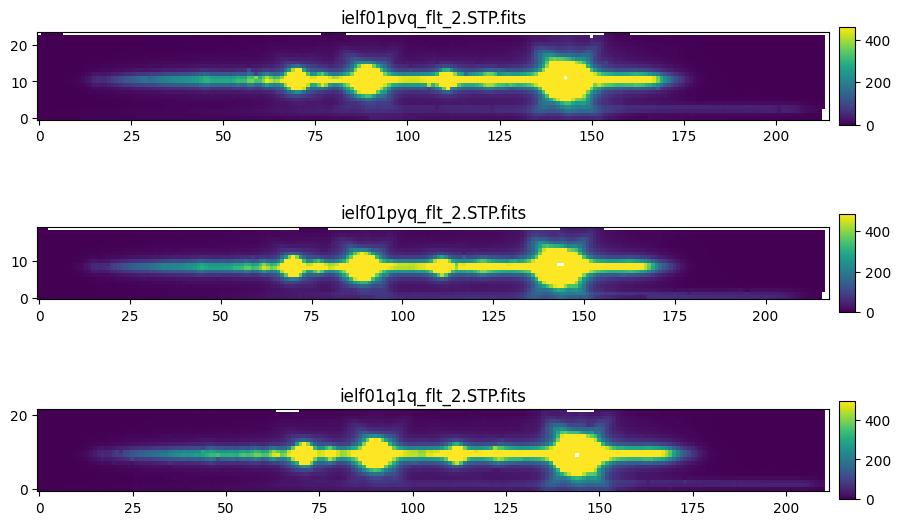

In [28]:
beam = '19'

fig, axes = plt.subplots(3, 1, figsize=(10,6))

for i, f in enumerate(glob.glob('OUTPUT/*STP.fits')):
    
    with fits.open(f) as hdul:
        d = hdul[f'BEAM_{beam}A'].data
    z1,z2 = zscale.zscale(d)
    im = axes[i].imshow(d, origin='lower', vmin=z1, vmax=z2)
    fig.colorbar(im,ax=axes[i],shrink=0.5, pad=0.01, aspect=6)
    axes[i].set_title(os.path.basename(f))
fig.tight_layout()

And now, we can finally look at our extracted spectra from the SPC files. For the example data, we've plotted the expected location of several emission lines that should be present in the planetary nebula spectrum (from Table 2 in [Bohlin et al. 2015](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2015/WFC3-2015-10.pdf)).

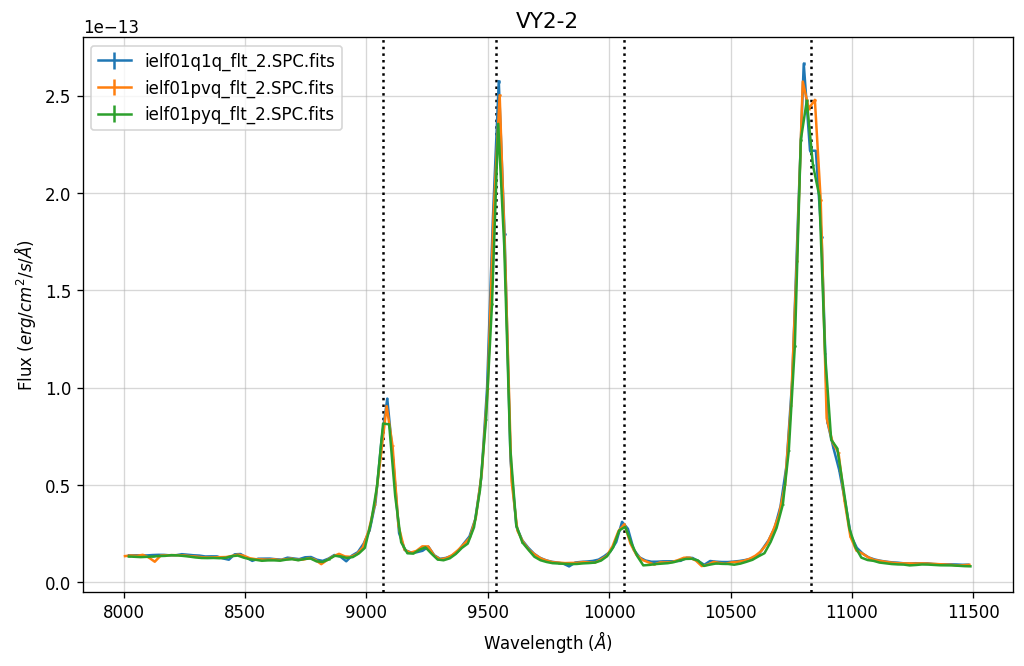

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=120)
ax.grid(alpha=0.5)

for i, f in enumerate(glob.glob('OUTPUT/*2.SPC.fits')):
    with fits.open(f) as hdul:
        d = hdul[f'BEAM_{beam}A'].data
        h = hdul[0].header
    wl = d['LAMBDA']
    flux = d['FLUX']
    error = d['FERROR']
    contam = d['CONTAM']
    xrange = (wl>8000) & (wl<11500)
        
    ax.errorbar(wl[xrange],flux[xrange],error[xrange], label=f'{os.path.basename(f)}')
        
# ax.set_title(os.path.basename(f))
ax.axvline(9070.0, ls=':', c='k') # SIII
ax.axvline(9535.1, ls=':', c='k') # SIII+P epsilon
ax.axvline(10060.2, ls=':', c='k') # HI P7
ax.axvline(10833.5, ls=':', c='k') # HeI

targname = h['targname']
ax.set_ylabel(r'Flux ($erg/cm^2/s/\AA$)')
ax.set_title(f'{targname}',size=13)
ax.set_xlabel(r'Wavelength ($\AA$)')
ax.legend(loc='upper left')

plt.show()

## 4.2 Fluxcube Extraction <a id="fluxcube"></a>

This more advanced extraction method will produce a final result that contains more accurate contamination estimates, and is weighted. We will achieve this by using the `aXedrizzle` functionality from HSTaXe, which will allow us to combine spectra taken at the same orientation. We will also make use of the segmentation map generated by SExtractor to determine the shape of the objects in our images.

The following steps will make use of the example data we used for the basic extraction above, as well as some additional images taken with a different direct imaging filter. We did a good deal of the required pre-processing for these images earlier, so we wouldn't have to repeat the same steps. Now, we'll create the aXe DRIZZLE directory, a directory to create our fluxcube in, and copy the drizzled direct and grism images we made in [Section 3.3](#drizzle). We'll also copy the set of grism images from the HSTaXe DATA directory, and the segmentation map output by SExtractor.

In [30]:
os.chdir(cwd)
if os.path.isdir('DRIZZLE'):
    shutil.rmtree('DRIZZLE')
os.makedirs('DRIZZLE/tmp')

os.environ['AXE_DRIZZLE_PATH'] = './DRIZZLE/'

In [31]:
os.chdir(cwd)
if os.path.isdir('flx'):
    shutil.rmtree('flx')
os.mkdir('flx')
dst = 'flx'

for d in ['g102', 'f098m', 'f105w']:
    f = f'{d}/{d}_drz.fits'
    shutil.copy(f, dst);

src = 'g102'
for f in glob.glob(f'{src}/*_flt.fits'):
    shutil.copy(f, dst);

src = 'example_data'
shutil.copy(f'{src}/seg.fits', 'flx');

Next, we'll create a file called `cube.lis` that contains a description of the drz images we're using, as well as the pivot wavelengths (in nm) and ABmag zeropoints for our direct filters.

In [32]:
os.chdir('flx')
direct_ims = glob.glob('f*drz.fits')

lis = open('cube.lis', 'w')

for f in direct_ims:
    photplam = fits.getval(f, 'PHOTPLAM', ext=0)  # pivot wavelength in Å
    photflam = fits.getval(f, 'PHOTFLAM', ext=0)  # inverse sensitivity in Å
    ab_zeropoint = -48.60 - 2.5*np.log10(photflam * photplam**2/3e18)  # f_nu = lambda**2 / c * f_lambda (c in Å/s since photplam in Å)
    line = f'{f} {photplam/10} {ab_zeropoint}'
    lis.write(line)
    lis.write('\n')
lis.close()

!cat cube.lis

f098m_drz.fits 986.47227 25.66524802988831
f105w_drz.fits 1055.1047 26.265326629151396


We'll now build our fluxcube (FLX) files using HSTaXe's `fcubeprep` task, using the drizzled grism image, the SExtractor segmentation map, and the list file we just generated as our inputs. This will give use an FLX file for each of the drizzled direct images, as well as one for each original grism image.

In [33]:
axetasks.fcubeprep(grism_image='g102_drz.fits', segm_image='seg.fits', filter_info='cube.lis',
                   AB_zero=True, dim_info=FOV)
os.chdir(cwd)
flx_files = glob.glob('flx/*FLX.fits')
dst = 'DATA/'
for f in flx_files:
    shutil.copy(f, dst);

Using default C-based coordinate transformation...


Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


Next, we'll re-run `axeprep` and `axecore` using the same input list as before, but we'll specify a fluxcube contamination model when running `axecore`.

In [34]:
axetasks.axeprep(inlist='aXe.lis',
                     configs='G102.F098M.V4.32.conf',
                     backgr=False,
                     norm=False,
                     mfwhm=3.0)

In [35]:
axetasks.axecore('aXe.lis',
                 'G102.F098M.V4.32.conf',
                 extrfwhm=4.,
                 drzfwhm=3.,
                 backfwhm=0.,
                 orient=False,
                 weights=True,
                 slitless_geom=False,
                 cont_model='fluxcube',
                 sampling='drizzle',
                 exclude=True)


Writing non-linear coefficients to file: DATA/ielf01pvq_flt_coeffs1.dat


Storing non-linear coefficients: 
WFC3: IR

DRZSCALE set to: 0.1282500028610229

Writing non-linear coefficients to file: DATA/ielf01pyq_flt_coeffs1.dat


Storing non-linear coefficients: 
WFC3: IR

DRZSCALE set to: 0.1282500028610229

Writing non-linear coefficients to file: DATA/ielf01q1q_flt_coeffs1.dat


Storing non-linear coefficients: 
WFC3: IR

DRZSCALE set to: 0.1282500028610229


We'll perform the last extraction step by running `drzprep` and `axedrizzle`, aliased here as `axecrr` ("cosmic ray reject"), which will drizzle the data for each source to give a single output spectrum, optimizing for the contamination estimate. We specify `opt_extr=True` to perform an optimal extraction in addition to a boxcar extraction. These outputs will be labeled with the suffix "_opt".

In [36]:
axetasks.drzprep(inlist='aXe.lis',
                 configs = 'G102.F098M.V4.32.conf',
                 back=False, 
                 opt_extr=True)

In [37]:
axetasks.axecrr(inlist='aXe.lis',
    configs='G102.F098M.V4.32.conf',
    infwhm = 4.0,
    outfwhm = 3.0,
    back = False,
    driz_separate = True,
    opt_extr=True)

Deleting old directory...
Creating temporary directory:  DRIZZLE/tmp
Object ID4: 1 empty contributors deleted.
Object ID37: 1 empty contributors deleted.
Object ID21: 3 empty contributors deleted.
Object ID17: 3 empty contributors deleted.
Object ID41: 2 empty contributors deleted.
Object ID5: 1 empty contributors deleted.
Object ID30: 1 empty contributors deleted.
Object ID33: 1 empty contributors deleted.
Object ID12: 2 empty contributors deleted.
Object ID6: 1 empty contributors deleted.
Object ID42: 1 empty contributors deleted.
Object ID7: 1 empty contributors deleted.
Object ID22: 1 empty contributors deleted.
Object ID36: 1 empty contributors deleted.
Drizzling object : ID4 ... 
Done!
Drizzling object : ID37 ... 
Done!
Drizzling object : ID40 ... 
Done!
Drizzling object : ID8 ... 
Done!
Drizzling object : ID9 ... 
Done!
Drizzling object : ID20 ... 
Done!
Drizzling object : ID5 ... 
Done!
Drizzling object : ID46 ... 
Done!
Drizzling object : ID11 ... 
Done!
Drizzling object : ID3

### 4.2.1 Fluxcube Outputs<a id="outcube"></a>

The stamp for the drizzled spectrum, as well as a stamp of the estimated contamination, is stored in the "mef" file labeled by the source ID.

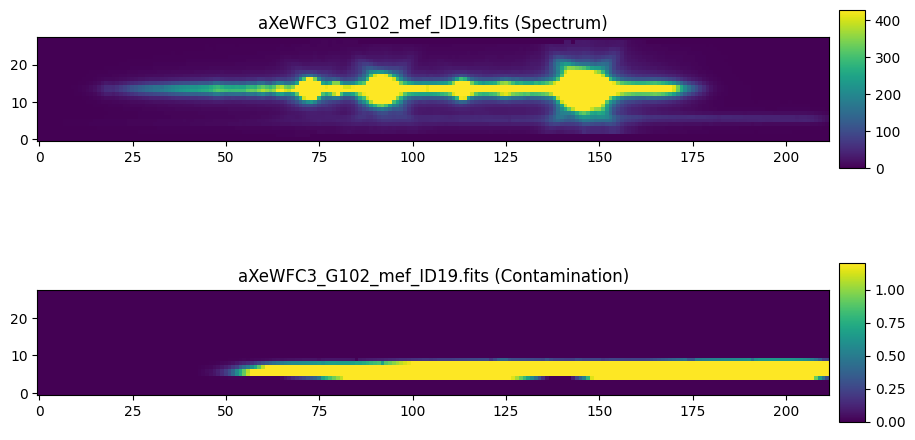

In [38]:
beam = '19'

fig, axes = plt.subplots(2, 1, figsize=(10,6))

f = glob.glob(f'DRIZZLE/*mef*{beam}*.fits')[0]
with fits.open(f) as hdul:
    d = hdul['SCI'].data
    cont = hdul['CON'].data
    
z1,z2 = zscale.zscale(d)
im = axes[0].imshow(d, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im,ax=axes[0],shrink=0.5, pad=0.01, aspect=6)
axes[0].set_title(f'{os.path.basename(f)} (Spectrum)')

z1,z2 = zscale.zscale(cont)
im = axes[1].imshow(cont, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im,ax=axes[1],shrink=0.5, pad=0.01, aspect=6)
axes[1].set_title(f'{os.path.basename(f)} (Contamination)')

fig.tight_layout()

Finally, we'll plot the 1D spectra from the individual grism images, along with the optimally extracted, drizzled spectrum.

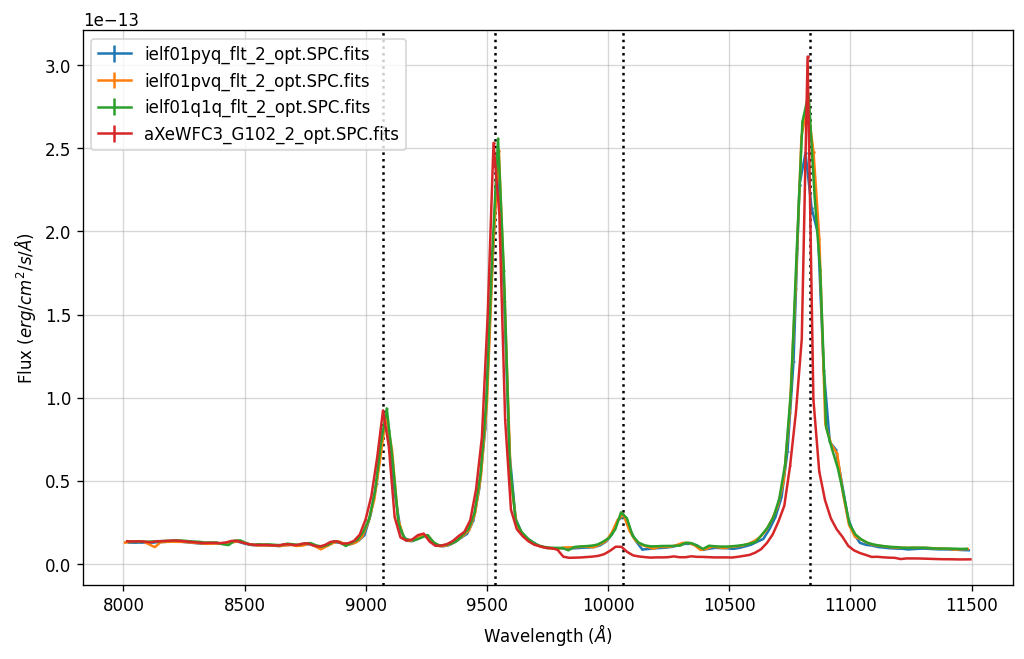

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=120)
ax.grid(alpha=0.5)

for i, f in enumerate(glob.glob('*/*2_opt.SPC.fits')):
    with fits.open(f) as hdul:
        d = hdul[f'BEAM_{beam}A'].data
        h = hdul[0].header
    wl = d['LAMBDA']
    flux = d['FLUX']
    error = d['FERROR']
    contam = d['CONTAM']
    xrange = (wl>8000) & (wl<11500)
        
    ax.errorbar(wl[xrange],flux[xrange],error[xrange], label=f'{os.path.basename(f)}')
        
# ax.set_title(os.path.basename(f))
ax.axvline(9070.0, ls=':', c='k') # SIII
ax.axvline(9535.1, ls=':', c='k') # SIII+P epsilon
ax.axvline(10060.2, ls=':', c='k') # HI P7
ax.axvline(10833.5, ls=':', c='k') # HeI


ax.set_ylabel(r'Flux ($erg/cm^2/s/\AA$)')
ax.set_xlabel(r'Wavelength ($\AA$)')
ax.legend(loc='upper left')

plt.show()

# 6. Conclusions <a id="conclusions"></a>

Thank you for walking through this notebook. You should now be able to perform extractions on WFC3/IR spectral data using HSTaXe.

For additional information on the WFC3 grisms, please visit the [grism resources](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources) and [grism data analysis](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources/grism-data-analysis) webpages.

Cookbooks walking through extraction methods for WFC3/UVIS and ACS/WFC are available on the [HSTaXe GitHub](https://github.com/spacetelescope/HSTaXe). For detailed information on HSTaXe, please visit the [documentation webpage](https://hstaxe.readthedocs.io/en/latest/index.html). Lastly, if you have questions regarding this notebook or using WFC3 data with HSTaXe please contact our WFC3 [Help Desk](https://stsci.service-now.com/hst).


**Congratulations, you have completed the notebook.**

## 7. About this Notebook <a id="about"></a>

**Author:** Aidan Pidgeon and Benjamin Kuhn, WFC3 Instrument Team

**Special Thanks to:** 
 - Dr. Nor Pirzkal, for creating the original workflow that was adapted into this notebook
 - Ricky O'Steen and Duy Nguyen, for their fantastic work in updating the HSTaXe module
 - Debopam Som, for support in testing HSTaXe and this notebook

**Released:** 2023-01-06 <br>
**Last Updated:** 2023-03-14

## 8. Citations <a id="cite"></a>

If you use `astropy`, `drizzlepac`, `matplotlib` or `numpy` for published research, please cite the
authors. Follow this link for more information about citing the libraries:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 